In [2]:
import scvelo as scv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import scanpy as sc
import sklearn
from io import StringIO
from Bio import Phylo
import re
from matplotlib.colors import ListedColormap
import phylovelo as pv
from copy import deepcopy
plt.rcParams['font.size'] = 12

In [3]:
vels = pd.read_csv('../megs/em3_erythoid.csv', index_col=0)

In [4]:
cmap = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan']
# cmap = ListedColormap(['tab:blue', 'tab:red', 'tab:orange', 'tab:green'])
color_map = dict(zip([9,36,13,22], [0, 3, 1, 2]))
state_map = dict(zip([9,36,13,22,32], ['primitive blood early', 'primitive blood progenitors', 'hematopoietic/endothelial progenitors', 'primitive blood late', 'angioblasts']))

In [5]:
data_path = '/data/liangzhen/wangk_embryogenesis/data/GSM3302826_embryo1/'
count = pd.read_csv(data_path+'scRNA_raw_counts.csv', index_col=0).T
metadata = pd.read_csv(data_path+'scRNA_metadata_blood_development.csv', index_col=0)
count = count.loc[metadata.index]

In [127]:
sd = pv.scData(count=count, cell_names=count.index, cell_states=metadata['cluster'].to_numpy())
sd.normalize_filter()
transfer_vel = []
for i in sd.x_normed.columns:
    if i in vels.index:
        transfer_vel.append(vels.loc[i]['velocity'])
    else:
        transfer_vel.append(0)
sd.velocity = np.array(transfer_vel)

In [128]:
sd.dimensionality_reduction('x_normed', pc_components=80, perplexity=10)

In [129]:
pv.velocity_embedding(sd, target='x_normed')

  0%|          | 0/84 [00:00<?, ?it/s]

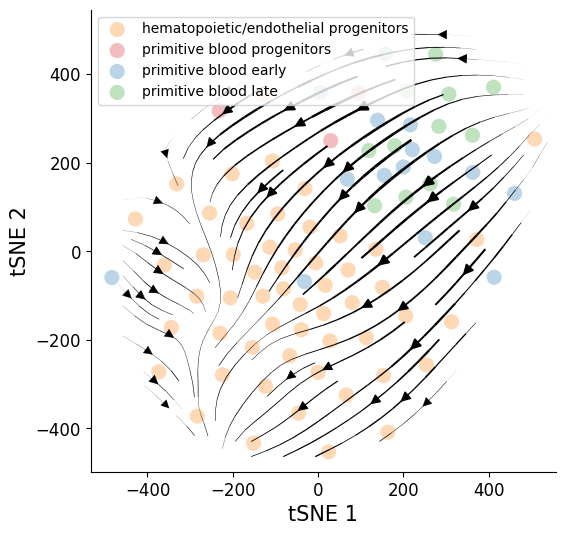

In [133]:
fig, ax = plt.subplots()
for i in [13,36,9,22]:
    ax.scatter(sd.Xdr.iloc[np.array(sd.cell_states)==i, 0], sd.Xdr.iloc[np.array(sd.cell_states)==i, 1], c=cmap[color_map[i]], edgecolors='none', s=120, alpha=0.3, label=state_map[i])
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1, radius=160, lw_coef=100, arrowsize=1.5)
ax.figure.set_size_inches(6, 6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.legend(fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig('./figures/embryo3_blood/stream.pdf', dpi='figure', format='pdf')

In [134]:
sd_em1 = deepcopy(sd)

In [7]:
import anndata as ad
import scanpy as sc

In [7]:
data_path = '/data/liangzhen/wangk_embryogenesis/data/GSM33028278_embryo2/'
count = pd.read_csv(data_path+'scRNA_raw_counts.csv', index_col=0).T
metadata = pd.read_csv(data_path+'scRNA_metadata_blood_development.csv', index_col=0)
count = count.loc[metadata.index]

In [8]:
count.shape

(2084, 18276)

In [8]:
adata = ad.AnnData(count)
sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)
sc.pp.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

In [12]:
sc.tl.tsne(adata)

In [9]:
sd = pv.scData(count=count, cell_names=count.index, cell_states=metadata['cluster'].to_numpy())
sd.normalize_filter()
transfer_vel = []
for i in sd.x_normed.columns:
    if i in vels.index:
        transfer_vel.append(vels.loc[i]['velocity'])
    else:
        transfer_vel.append(0)
sd.velocity = np.array(transfer_vel)

In [ ]:
sd.dimensionality_reduction('x_normed', perplexity=10, random_state=2)
pv.velocity_embedding(sd, target='x_normed')

  0%|          | 0/2084 [00:00<?, ?it/s]

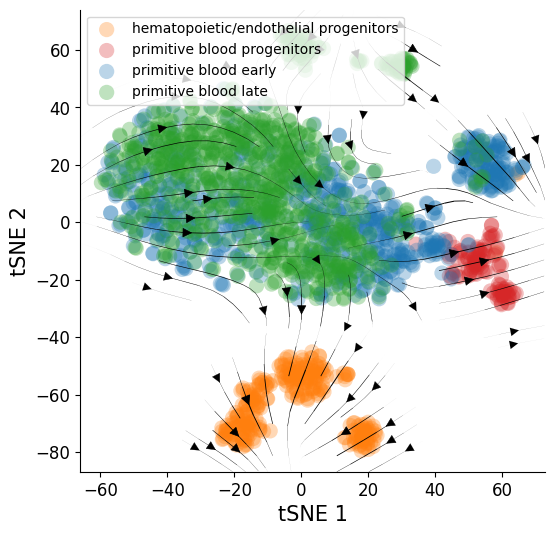

In [28]:
fig, ax = plt.subplots()
for i in [13,36,9,22]:
    ax.scatter(sd.Xdr.iloc[np.array(sd.cell_states)==i, 0], sd.Xdr.iloc[np.array(sd.cell_states)==i, 1], c=cmap[color_map[i]], edgecolors='none', s=120, alpha=0.3, label=state_map[i])
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1, radius=10, lw_coef=1000, arrowsize=1.5)
ax.figure.set_size_inches(6, 6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.legend(fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig('./figures/embryo3_blood/stream.pdf', dpi='figure', format='pdf')

In [30]:
import dynamo as dyn
import anndata as ad
adata = ad.AnnData(sd.x_normed)
adata.obsm['X_tsne'] = sd.Xdr.to_numpy()
adata.obsm['velocity_tsne'] = sd.velocity_embeded
adata.obs['cell_states'] = pd.Series([state_map[i] for i in sd.cell_states], index=sd.cell_names)

|-----> setting visualization default mode in dynamo. Your customized matplotlib settings might be overritten.


|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: TSNE. 
        Vector field will be learned in the TSNE space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [0.3782s]
|-----> <insert> velocity_tsne_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_tsne_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_tsne to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in tsne basis...
|-----> graphizing vectorfield...
|-----------> calculating neighbor indices...
|-----> [ddhodge completed] in progress: 100.0000%
|-----> [ddhodge completed] finished [4.3693s]
|-----> Computing curl...


Calculating 2-D curl: 100%|██████████| 2084/2084 [00:00<00:00, 11905.91it/s]

|-----> Computing divergence...



Calculating divergence: 100%|██████████| 3/3 [00:00<00:00, 28.24it/s]

|-----> <insert> control_point_tsne to obs in AnnData Object.
|-----> <insert> inlier_prob_tsne to obs in AnnData Object.


|-----> <insert> obs_vf_angle_tsne to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [5.1546s]
|-----> fetch computation results from adata.obsp[tsne_ddhodge]...
|-----> [ddhodge completed] in progress: 100.0000%
|-----> [ddhodge completed] finished [3.2499s]
|-----------> plotting with basis key=X_tsne
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


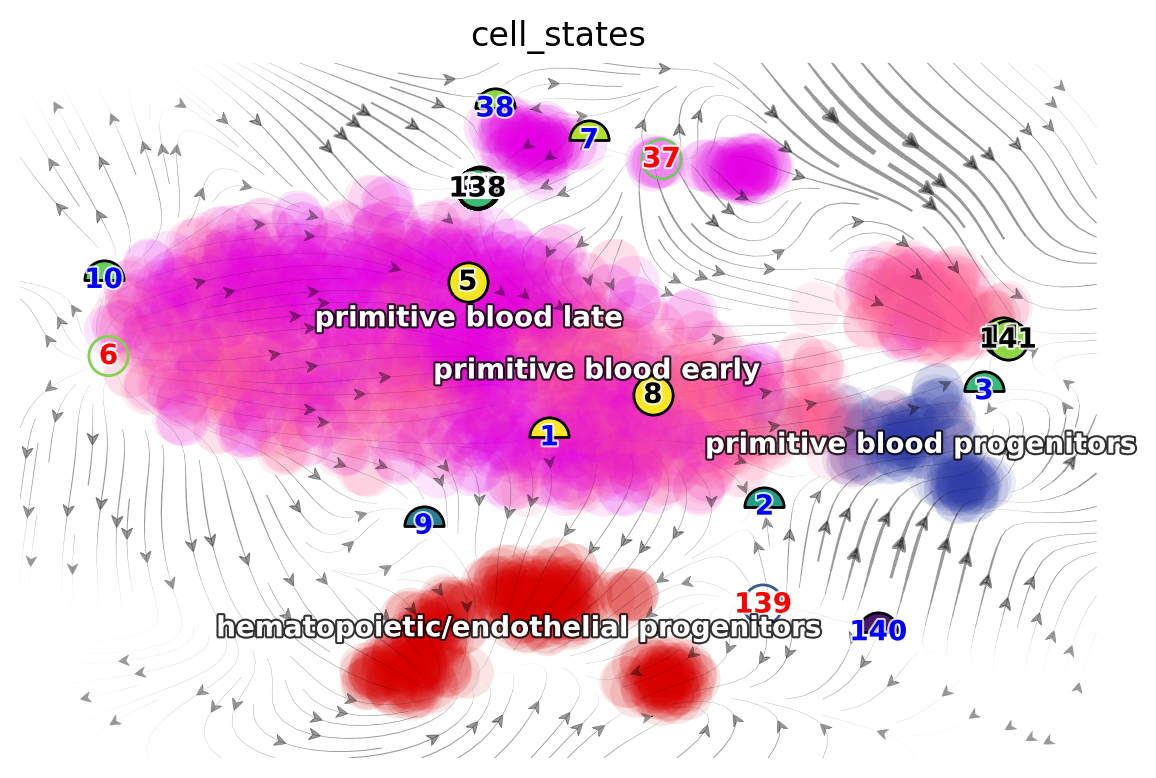

In [32]:
dyn.vf.VectorField(adata, basis='tsne', M=1000, pot_curl_div=True)
dyn.vf.topography(adata, basis='tsne')
dyn.ext.ddhodge(adata, basis='tsne')
dyn.pl.topography(adata, color='cell_states', basis='tsne', fps_basis='tsne')

In [33]:
dyn.pd.state_graph(adata, group='cell_states', basis='tsne', method='vf', sample_num=100)

|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree computation] in progress: 100.0000%in progress: 0.0000%
|-----> [KDTree computation] finished [0.0008s]
|-----> [iterate groups] in progress: 25.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 326.32it/s]


|-----> [iterate groups] in progress: 50.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 308.56it/s]


|-----> [iterate groups] in progress: 75.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 380.82it/s]


|-----> [iterate groups] in progress: 100.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 390.40it/s]


|-----> [iterate groups] in progress: 100.0000%
|-----> [iterate groups] finished [3.8914s]
|-----> [State graph estimation] in progress: 100.0000%
|-----> [State graph estimation] finished [0.0019s]


AnnData object with n_obs × n_vars = 2084 × 11572
    obs: 'cell_states', 'tsne_ddhodge_div', 'tsne_ddhodge_potential', 'curl_tsne', 'divergence_tsne', 'control_point_tsne', 'inlier_prob_tsne', 'obs_vf_angle_tsne'
    uns: 'cell_states_colors', 'VecFld_tsne', 'cell_states_graph'
    obsm: 'X_tsne', 'velocity_tsne', 'velocity_tsne_SparseVFC', 'X_tsne_SparseVFC'
    obsp: 'tsne_ddhodge'

In [48]:
color_keys = {'hematopoietic/endothelial progenitors':'tab:orange', 
              'hematopoietic/endothelial progen':'tab:orange',
               'primitive blood progenitors':'tab:red',
               'primitive blood early':'tab:blue',
               'primitive blood late':'tab:green'}

|-----------> plotting with basis key=X_tsne
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


<Figure size 640x480 with 0 Axes>

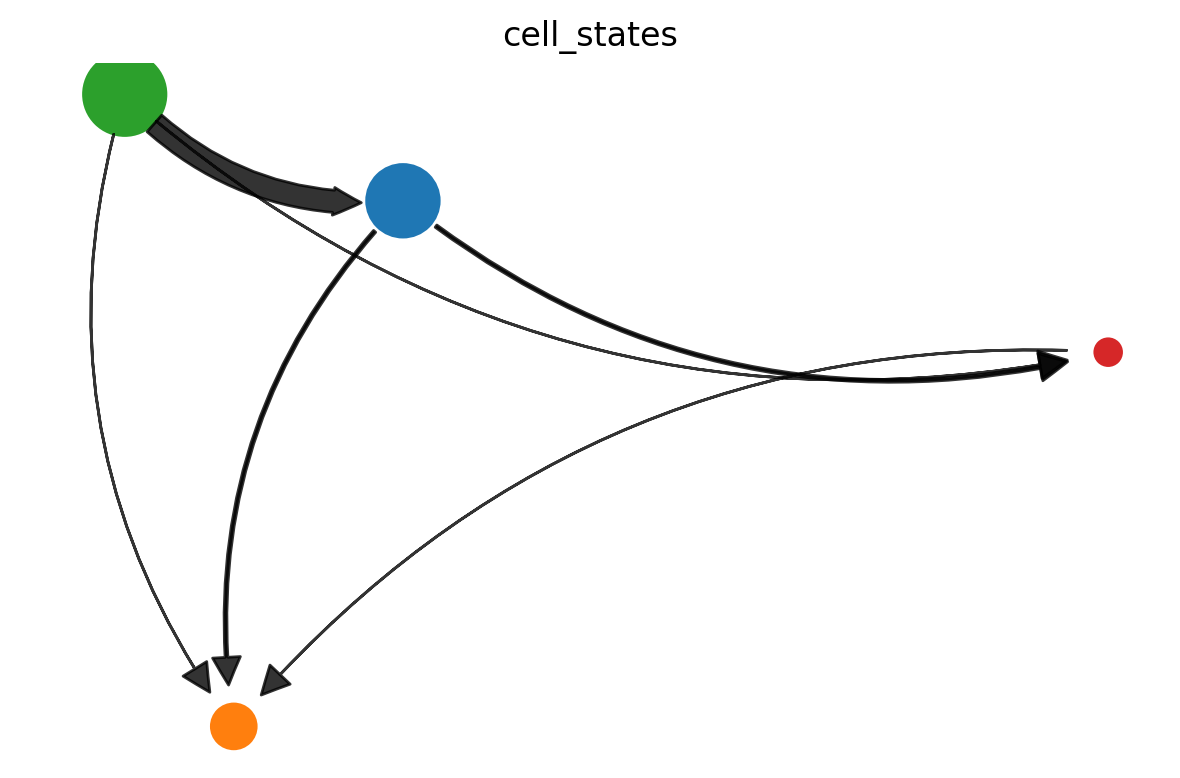

In [61]:
dyn.pl.state_graph(adata,
                   color=['cell_states'],
                   group='cell_states',
                   basis='tsne',
                   show_legend=False,
                   method='vf',
                   edge_scale=0.5,
                   color_key=color_keys,
                   graph_alpha=0.8*np.ones((4,4))
                  )

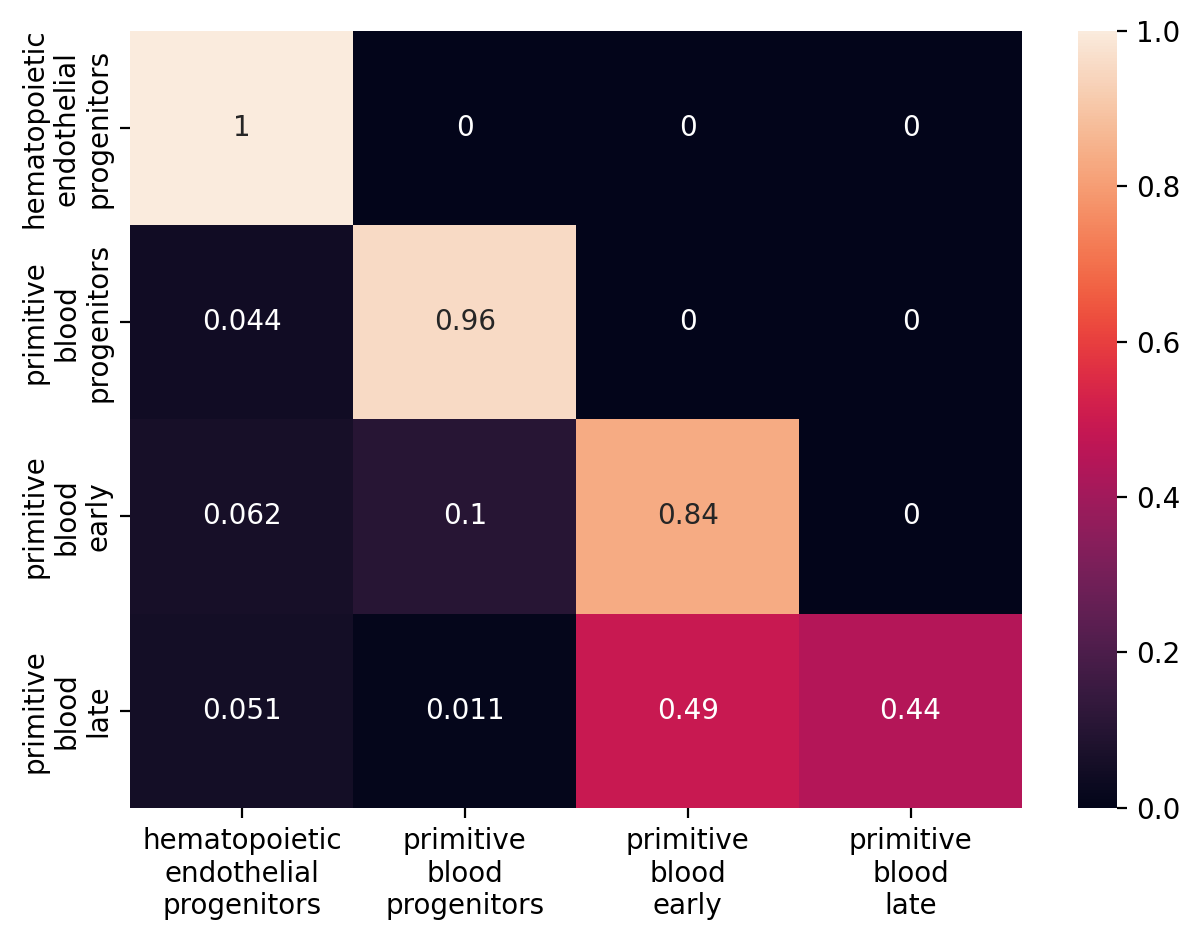

In [105]:
transition_mat = adata.uns['cell_states_graph']['group_graph']
transition_groups = adata.uns['cell_states_graph']['group_names']
transition_mat = pd.DataFrame(transition_mat, index=transition_groups, columns=transition_groups)

order = ['hematopoietic/endothelial progenitors', 
         'primitive blood progenitors',
         'primitive blood early',
         'primitive blood late']

import seaborn as sns
fig, ax = plt.subplots()
transition_mat = transition_mat[order].loc[order]
transition_mat = transition_mat/transition_mat.sum(1)
transition_mat.index = [i.replace(' ', '\n').replace('/', '\n') for i in transition_mat.index]
transition_mat.columns = transition_mat.index
sns.heatmap(transition_mat, annot=True, ax=ax)
for label in ax.get_yticklabels():
    label.set_horizontalalignment('center')
    label.set_fontsize(10)
    label.set_position((label.get_position()[0]-0.05, label.get_position()[1]))
for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')
    label.set_fontsize(10)
    
ax.yaxis.set_label_coords(1, 1)
plt.tight_layout()
plt.show()

In [90]:
sd_em2 = deepcopy(sd)

In [9]:
data_path = '/data/liangzhen/wangk_embryogenesis/data/GSM3302830_embryo4/'
count = pd.read_csv(data_path+'scRNA_raw_counts.csv', index_col=0).T
metadata = pd.read_csv(data_path+'scRNA_metadata_blood_development.csv', index_col=0)
count = count.loc[metadata.index]

In [10]:
count.shape

(4018, 16556)

In [92]:
sd = pv.scData(count=count, cell_names=count.index, cell_states=metadata['cluster'].to_numpy())
sd.normalize_filter()
transfer_vel = []
for i in sd.x_normed.columns:
    if i in vels.index:
        transfer_vel.append(vels.loc[i]['velocity'])
    else:
        transfer_vel.append(0)
sd.velocity = np.array(transfer_vel)

In [93]:
sd.dimensionality_reduction('x_normed', perplexity=10)
pv.velocity_embedding(sd, target='x_normed')

  0%|          | 0/4018 [00:00<?, ?it/s]

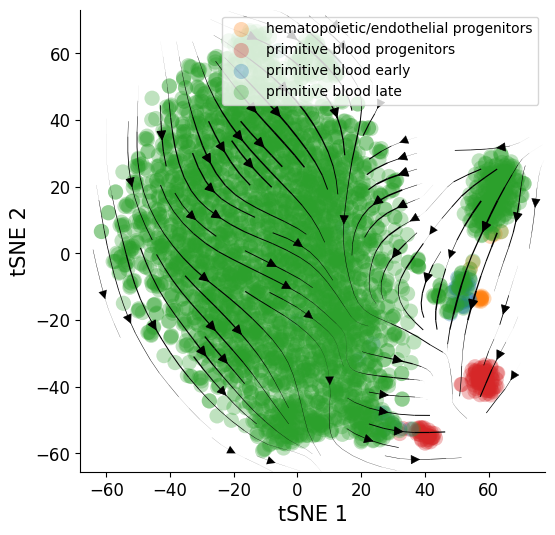

In [98]:
fig, ax = plt.subplots()
for i in [13,36,9,22]:
    ax.scatter(sd.Xdr.iloc[np.array(sd.cell_states)==i, 0], sd.Xdr.iloc[np.array(sd.cell_states)==i, 1], c=cmap[color_map[i]], edgecolors='none', s=120, alpha=0.3, label=state_map[i])
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1, radius=8, lw_coef=5000, arrowsize=1.5)
ax.figure.set_size_inches(6, 6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.legend(fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig('./figures/embryo3_blood/stream.pdf', dpi='figure', format='pdf')

In [100]:
sd_em4 = deepcopy(sd)

In [11]:
data_path = '/data/liangzhen/wangk_embryogenesis/data/GSM3302831_embryo5/'
count = pd.read_csv(data_path+'scRNA_raw_counts.csv', index_col=0).T
metadata = pd.read_csv(data_path+'scRNA_metadata_blood_development.csv', index_col=0)
count = count.loc[metadata.index]

In [12]:
count.shape

(1045, 17595)

In [107]:
sd = pv.scData(count=count, cell_names=count.index, cell_states=metadata['cluster'].to_numpy())
sd.normalize_filter()
transfer_vel = []
for i in sd.x_normed.columns:
    if i in vels.index:
        transfer_vel.append(vels.loc[i]['velocity'])
    else:
        transfer_vel.append(0)
sd.velocity = np.array(transfer_vel)

In [108]:
sd.dimensionality_reduction('x_normed', perplexity=10)
pv.velocity_embedding(sd, target='x_normed')

  0%|          | 0/1045 [00:00<?, ?it/s]

In [109]:
fig, ax = plt.subplots()
for i in [13,36,9,22]:
    ax.scatter(sd.Xdr.iloc[np.array(sd.cell_states)==i, 0], sd.Xdr.iloc[np.array(sd.cell_states)==i, 1], c=cmap[color_map[i]], edgecolors='none', s=120, alpha=0.3, label=state_map[i])
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1, radius=5, lw_coef=5000, arrowsize=1.5)
ax.figure.set_size_inches(6, 6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.legend(fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig('./figures/embryo3_blood/stream.pdf', dpi='figure', format='pdf')

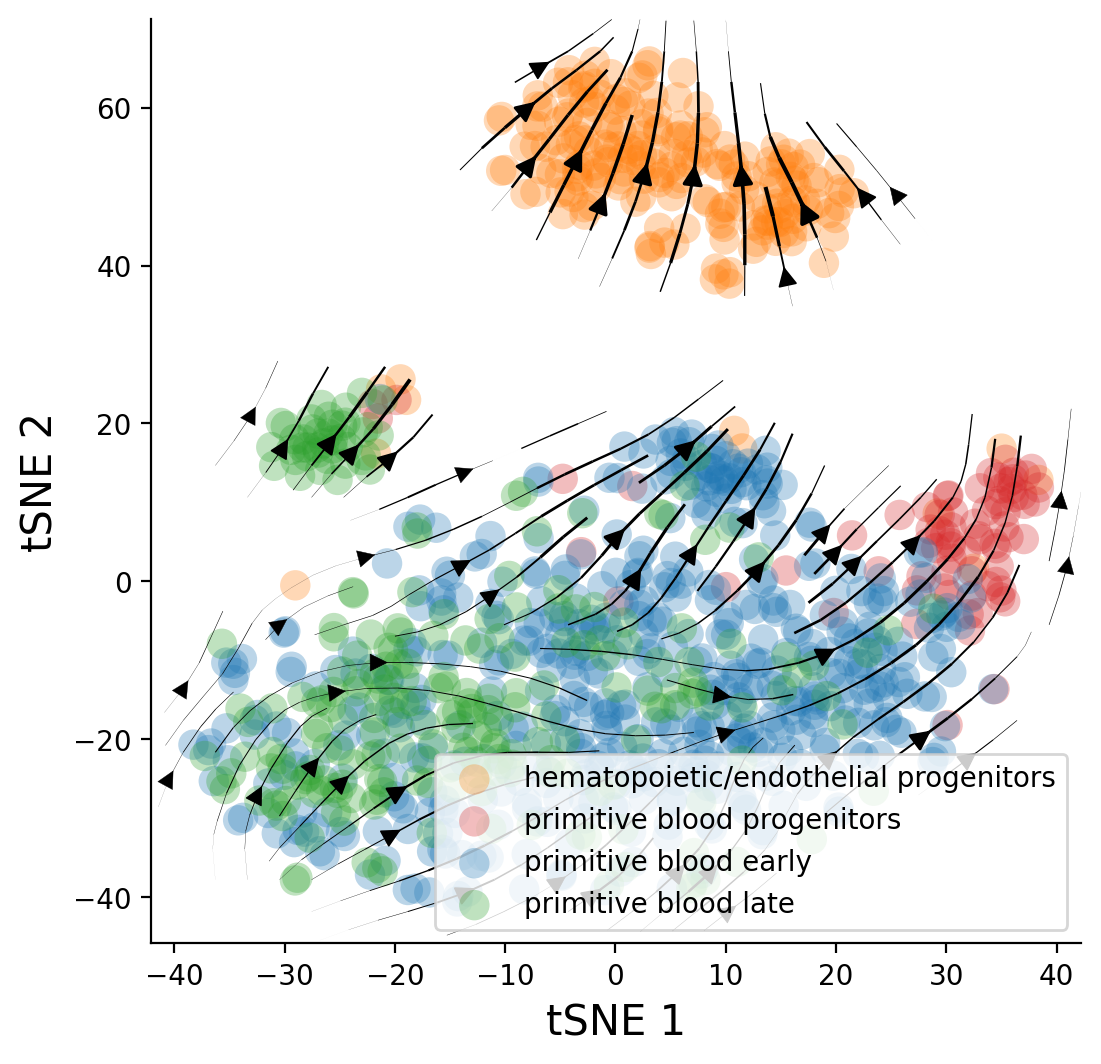

In [110]:
plt.show()

In [112]:
import dynamo as dyn
import anndata as ad
adata = ad.AnnData(sd.x_normed)
adata.obsm['X_tsne'] = sd.Xdr.to_numpy()
adata.obsm['velocity_tsne'] = sd.velocity_embeded
adata.obs['cell_states'] = pd.Series([state_map[i] for i in sd.cell_states], index=sd.cell_names)

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: TSNE. 
        Vector field will be learned in the TSNE space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [0.1815s]
|-----> <insert> velocity_tsne_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_tsne_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_tsne to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in tsne basis...
|-----> graphizing vectorfield...
|-----------> calculating neighbor indices...
|-----> [ddhodge completed] in progress: 100.0000%
|-----> [ddhodge completed] finished [0.9276s]
|-----> Computing curl...


Calculating 2-D curl: 100%|██████████| 1045/1045 [00:00<00:00, 8703.28it/s]

|-----> Computing divergence...



Calculating divergence: 100%|██████████| 2/2 [00:00<00:00, 37.60it/s]

|-----> <insert> control_point_tsne to obs in AnnData Object.
|-----> <insert> inlier_prob_tsne to obs in AnnData Object.


|-----> <insert> obs_vf_angle_tsne to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [1.3617s]
|-----> fetch computation results from adata.obsp[tsne_ddhodge]...
|-----> [ddhodge completed] in progress: 100.0000%
|-----> [ddhodge completed] finished [0.4564s]
|-----------> plotting with basis key=X_tsne
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


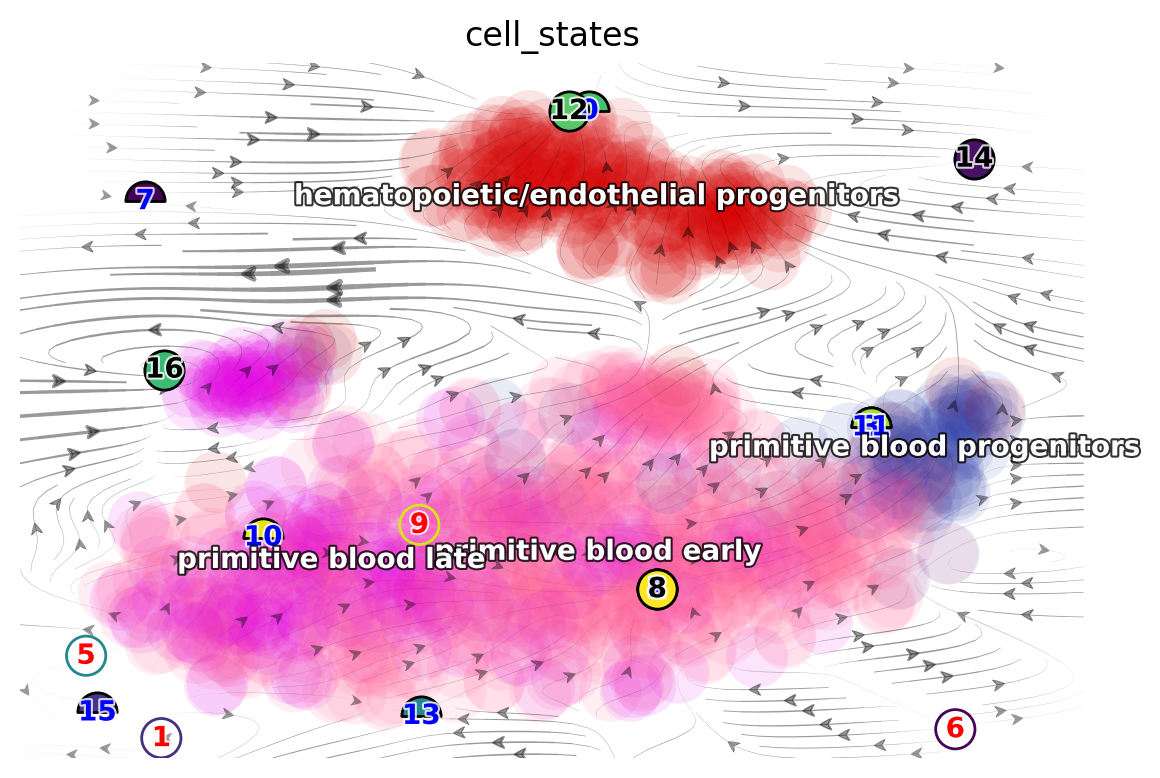

In [113]:
dyn.vf.VectorField(adata, basis='tsne', M=1000, pot_curl_div=True)
dyn.vf.topography(adata, basis='tsne')
dyn.ext.ddhodge(adata, basis='tsne')
dyn.pl.topography(adata, color='cell_states', basis='tsne', fps_basis='tsne')

|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree computation] in progress: 100.0000%in progress: 0.0000%
|-----> [KDTree computation] finished [0.0004s]
|-----> [iterate groups] in progress: 25.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 318.09it/s]


|-----> [iterate groups] in progress: 50.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 325.80it/s]


|-----> [iterate groups] in progress: 75.0000%

uniformly sampling points along a trajectory: 100%|██████████| 75/75 [00:00<00:00, 342.87it/s]


|-----> [iterate groups] in progress: 100.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 375.80it/s]


|-----> [iterate groups] in progress: 100.0000%
|-----> [iterate groups] finished [3.9330s]
|-----> [State graph estimation] in progress: 100.0000%
|-----> [State graph estimation] finished [0.0018s]
|-----------> plotting with basis key=X_tsne
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


<Figure size 640x480 with 0 Axes>

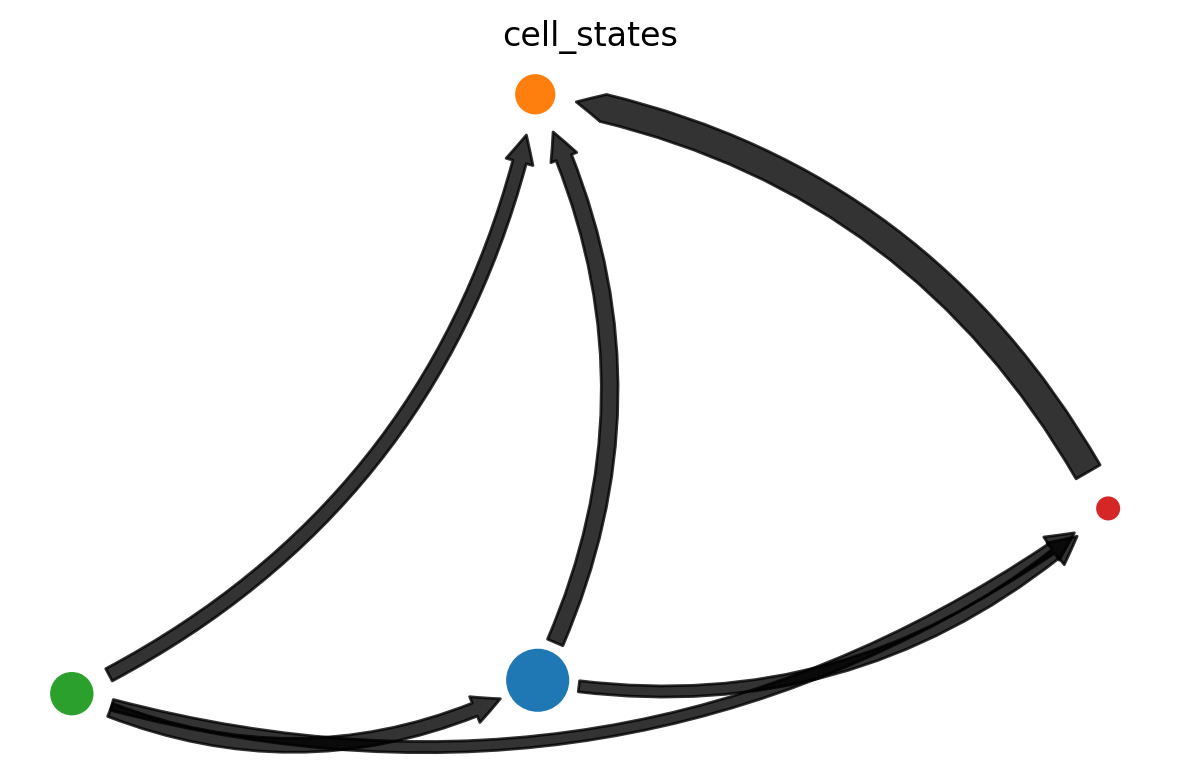

In [116]:
dyn.pd.state_graph(adata, group='cell_states', basis='tsne', method='vf', sample_num=100)

|-----------> plotting with basis key=X_tsne
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


<Figure size 640x480 with 0 Axes>

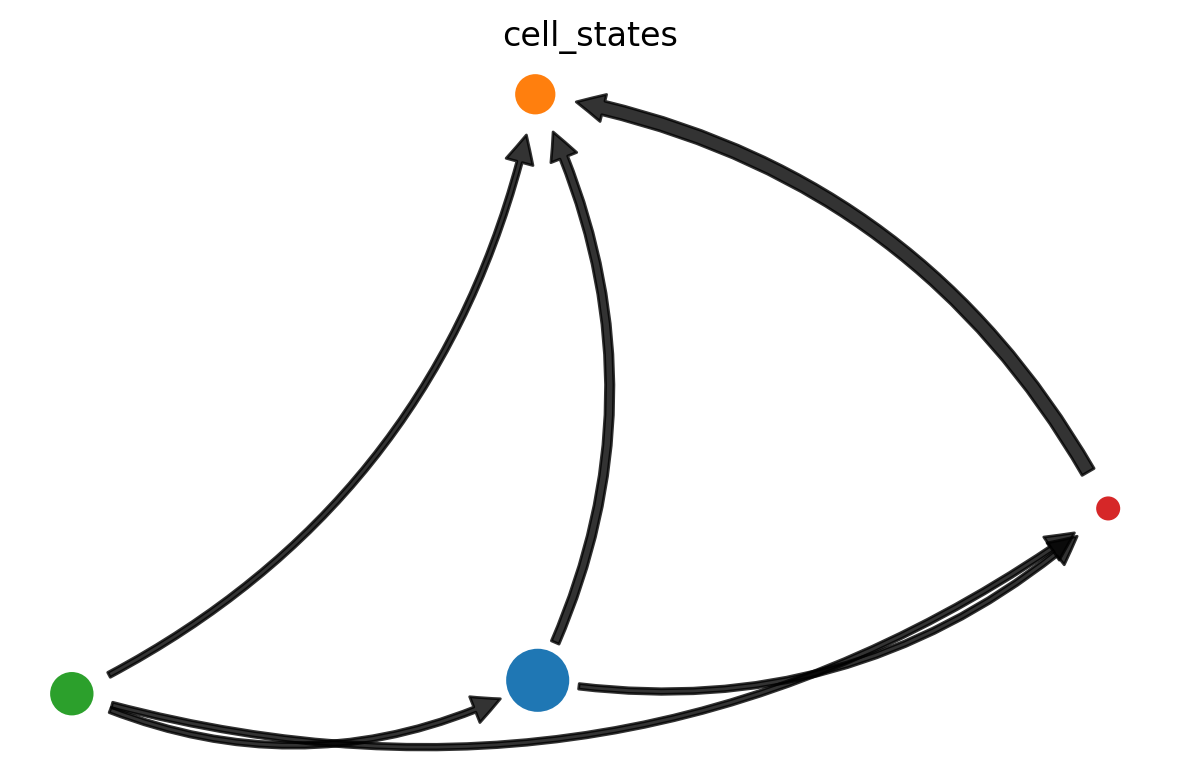

In [117]:
dyn.pl.state_graph(adata,
                   color=['cell_states'],
                   group='cell_states',
                   basis='tsne',
                   show_legend=False,
                   method='vf',
                   edge_scale=1,
                   color_key=color_keys,
                   graph_alpha=0.8*np.ones((4,4))
                  )

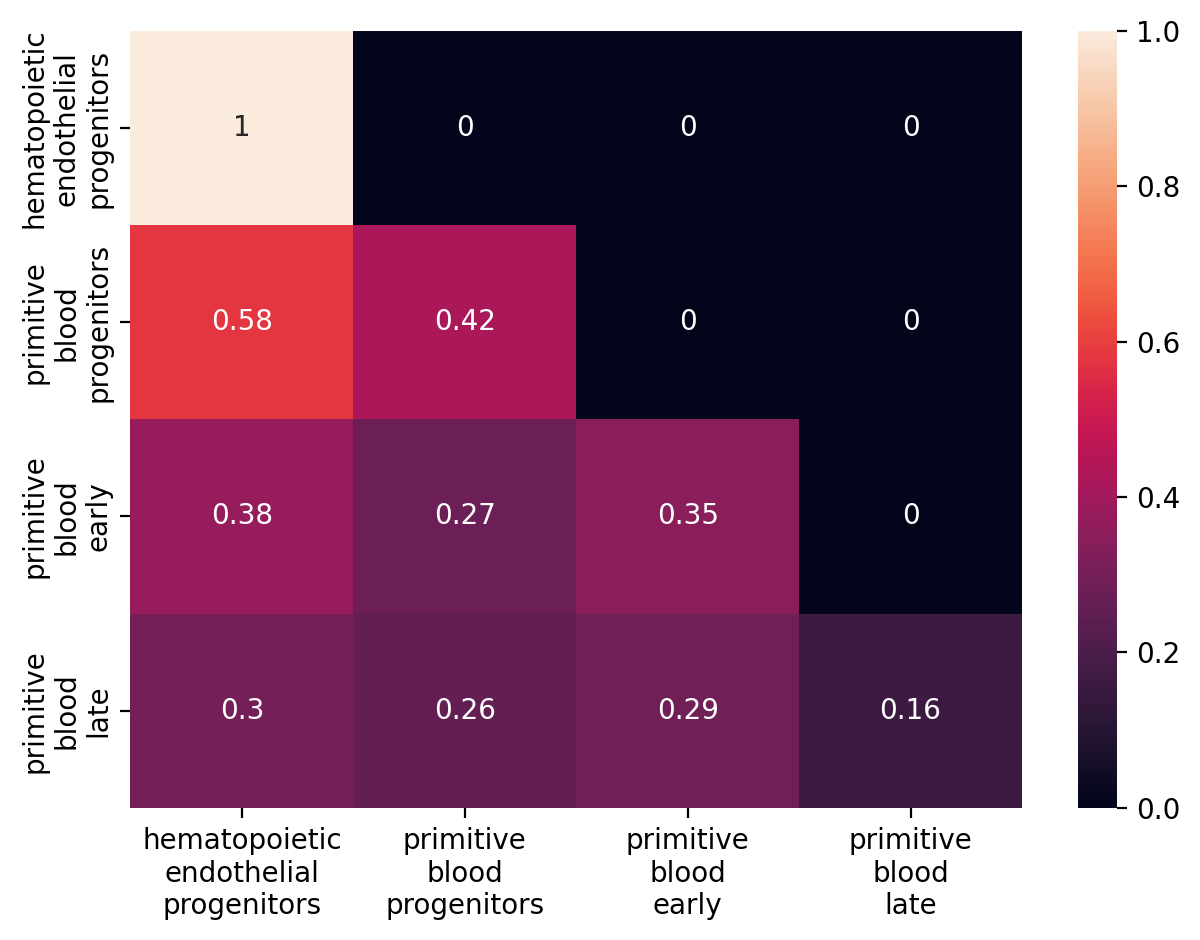

In [118]:
transition_mat = adata.uns['cell_states_graph']['group_graph']
transition_groups = adata.uns['cell_states_graph']['group_names']
transition_mat = pd.DataFrame(transition_mat, index=transition_groups, columns=transition_groups)

order = ['hematopoietic/endothelial progenitors', 
         'primitive blood progenitors',
         'primitive blood early',
         'primitive blood late']

import seaborn as sns
fig, ax = plt.subplots()
transition_mat = transition_mat[order].loc[order]
transition_mat = transition_mat/transition_mat.sum(1)
transition_mat.index = [i.replace(' ', '\n').replace('/', '\n') for i in transition_mat.index]
transition_mat.columns = transition_mat.index
sns.heatmap(transition_mat, annot=True, ax=ax)
for label in ax.get_yticklabels():
    label.set_horizontalalignment('center')
    label.set_fontsize(10)
    label.set_position((label.get_position()[0]-0.05, label.get_position()[1]))
for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')
    label.set_fontsize(10)
    
ax.yaxis.set_label_coords(1, 1)
plt.tight_layout()
plt.show()

In [111]:
sd_em5 = deepcopy(sd)

In [13]:
data_path = '/data/liangzhen/wangk_embryogenesis/data/GSM3302832_embryo6/'
count = pd.read_csv(data_path+'scRNA_raw_counts.csv', index_col=0).T
metadata = pd.read_csv(data_path+'scRNA_metadata_blood_development.csv', index_col=0)
count = count.loc[metadata.index]

In [14]:
count.shape

(1043, 17377)

In [123]:
sd = pv.scData(count=count, cell_names=count.index, cell_states=metadata['cluster'].to_numpy())
sd.normalize_filter()
transfer_vel = []
for i in sd.x_normed.columns:
    if i in vels.index:
        transfer_vel.append(vels.loc[i]['velocity'])
    else:
        transfer_vel.append(0)
sd.velocity = np.array(transfer_vel)

In [124]:
sd.dimensionality_reduction('x_normed', perplexity=10)
pv.velocity_embedding(sd, target='x_normed')

  0%|          | 0/1043 [00:00<?, ?it/s]

In [125]:
fig, ax = plt.subplots()
for i in [13,36,9,22]:
    ax.scatter(sd.Xdr.iloc[np.array(sd.cell_states)==i, 0], sd.Xdr.iloc[np.array(sd.cell_states)==i, 1], c=cmap[color_map[i]], edgecolors='none', s=120, alpha=0.3, label=state_map[i])
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1, radius=5, lw_coef=5000, arrowsize=1.5)
ax.figure.set_size_inches(6, 6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.legend(fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig('./figures/embryo3_blood/stream.pdf', dpi='figure', format='pdf')

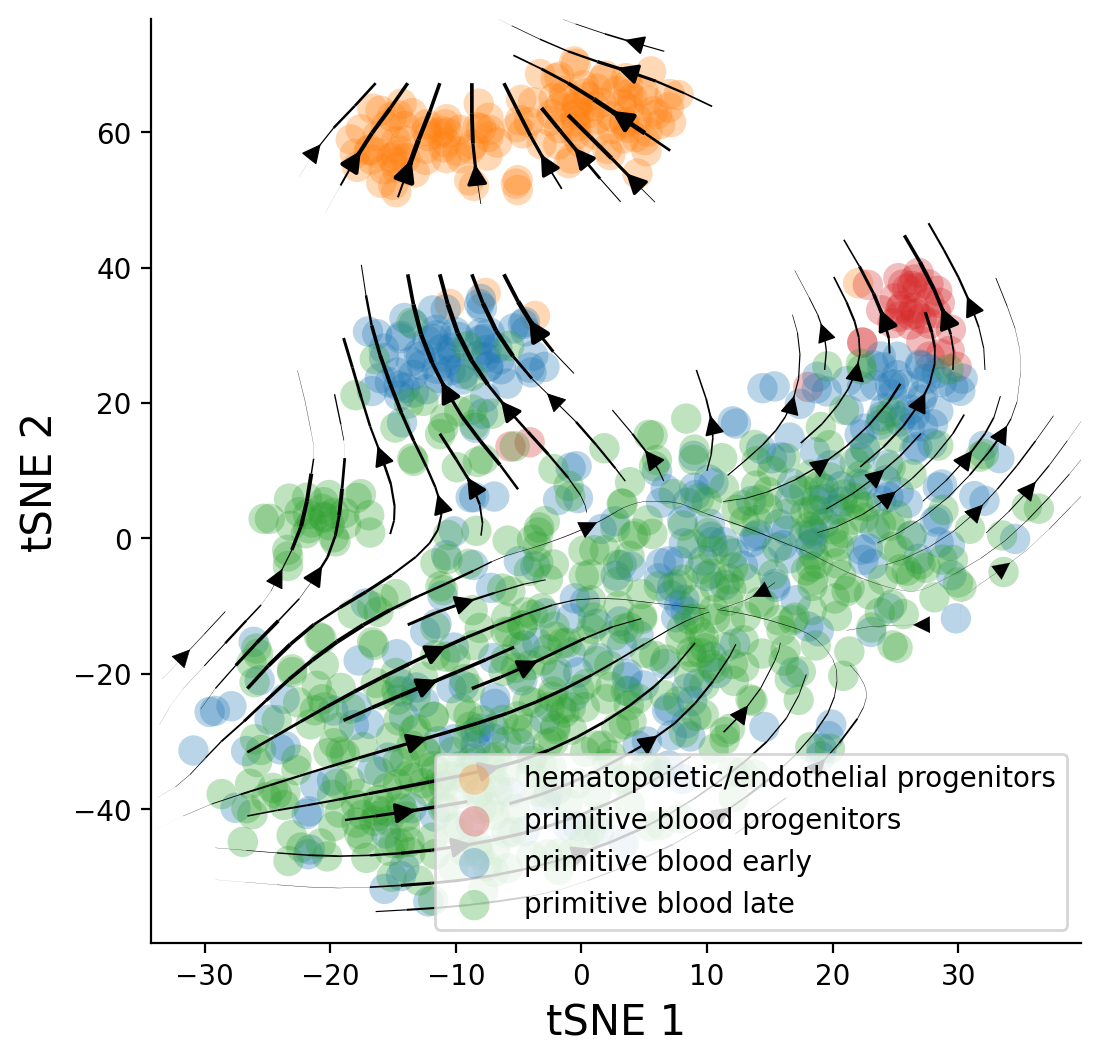

In [127]:
plt.show()

In [126]:
sd_em6 = deepcopy(sd)

In [128]:
import dynamo as dyn
import anndata as ad
adata = ad.AnnData(sd.x_normed)
adata.obsm['X_tsne'] = sd.Xdr.to_numpy()
adata.obsm['velocity_tsne'] = sd.velocity_embeded
adata.obs['cell_states'] = pd.Series([state_map[i] for i in sd.cell_states], index=sd.cell_names)

|-----> VectorField reconstruction begins...
|-----> Retrieve X and V based on basis: TSNE. 
        Vector field will be learned in the TSNE space.
|-----> Generating high dimensional grids and convert into a row matrix.
|-----> Learning vector field with method: sparsevfc.
|-----> [SparseVFC] begins...
|-----> Sampling control points based on data velocity magnitude...
|-----> [SparseVFC] in progress: 100.0000%
|-----> [SparseVFC] finished [0.1894s]
|-----> <insert> velocity_tsne_SparseVFC to obsm in AnnData Object.
|-----> <insert> X_tsne_SparseVFC to obsm in AnnData Object.
|-----> <insert> VecFld_tsne to uns in AnnData Object.
|-----> Running ddhodge to estimate vector field based pseudotime in tsne basis...
|-----> graphizing vectorfield...
|-----------> calculating neighbor indices...
|-----> [ddhodge completed] in progress: 100.0000%
|-----> [ddhodge completed] finished [0.9196s]
|-----> Computing curl...


Calculating 2-D curl: 100%|██████████| 1043/1043 [00:00<00:00, 8949.85it/s]

|-----> Computing divergence...



Calculating divergence: 100%|██████████| 2/2 [00:00<00:00, 38.03it/s]

|-----> <insert> control_point_tsne to obs in AnnData Object.
|-----> <insert> inlier_prob_tsne to obs in AnnData Object.


|-----> <insert> obs_vf_angle_tsne to obs in AnnData Object.
|-----> [VectorField] in progress: 100.0000%
|-----> [VectorField] finished [1.3508s]
|-----> fetch computation results from adata.obsp[tsne_ddhodge]...
|-----> [ddhodge completed] in progress: 100.0000%
|-----> [ddhodge completed] finished [0.4513s]
|-----------> plotting with basis key=X_tsne
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


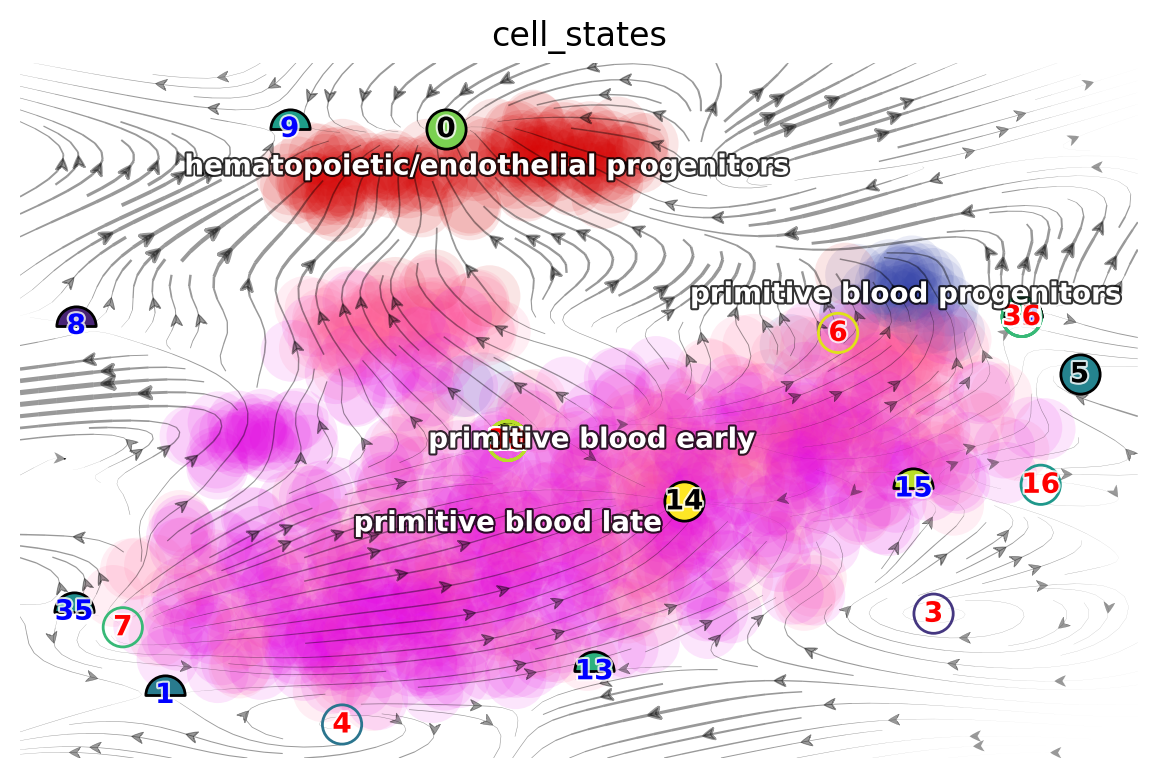

In [129]:
dyn.vf.VectorField(adata, basis='tsne', M=1000, pot_curl_div=True)
dyn.vf.topography(adata, basis='tsne')
dyn.ext.ddhodge(adata, basis='tsne')
dyn.pl.topography(adata, color='cell_states', basis='tsne', fps_basis='tsne')

In [142]:
for _ in range(100):
    try:
        dyn.pd.state_graph(adata, group='cell_states', basis='tsne', method='vf', sample_num=100)
        break
    except:
        continue

|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree computation] in progress: 100.0000%in progress: 0.0000%
|-----> [KDTree computation] finished [0.0017s]
|-----> [iterate groups] in progress: 25.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 386.72it/s]


|-----> [iterate groups] in progress: 50.0000%

uniformly sampling points along a trajectory:  43%|████▎     | 43/100 [00:00<00:00, 397.27it/s]

calc_fft_k run failed...
|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree computation] in progress: 100.0000%in progress: 0.0000%
|-----> [KDTree computation] finished [0.0004s]
|-----> [iterate groups] in progress: 25.0000%


uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 401.62it/s]


|-----> [iterate groups] in progress: 50.0000%

uniformly sampling points along a trajectory:  53%|█████▎    | 53/100 [00:00<00:00, 387.23it/s]

calc_fft_k run failed...
|-----> Estimating the transition probability between cell types...
|-----> Applying vector field


|-----> [KDTree computation] in progress: 100.0000%in progress: 0.0000%
|-----> [KDTree computation] finished [0.0003s]
|-----> [iterate groups] in progress: 25.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 393.27it/s]


|-----> [iterate groups] in progress: 50.0000%

uniformly sampling points along a trajectory:   3%|▎         | 3/100 [00:00<00:00, 151.17it/s]

calc_fft_k run failed...
|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree computation] in progress: 100.0000%in progress: 0.0000%
|-----> [KDTree computation] finished [0.0003s]
|-----> [iterate groups] in progress: 25.0000%


uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 386.60it/s]


|-----> [iterate groups] in progress: 50.0000%

uniformly sampling points along a trajectory:  71%|███████   | 71/100 [00:00<00:00, 399.12it/s]

calc_fft_k run failed...
|-----> Estimating the transition probability between cell types...
|-----> Applying vector field


|-----> [KDTree computation] in progress: 100.0000%in progress: 0.0000%
|-----> [KDTree computation] finished [0.0003s]
|-----> [iterate groups] in progress: 25.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 390.40it/s]


|-----> [iterate groups] in progress: 50.0000%

uniformly sampling points along a trajectory:  84%|████████▍ | 84/100 [00:00<00:00, 390.45it/s]

calc_fft_k run failed...
|-----> Estimating the transition probability between cell types...
|-----> Applying vector field
|-----> [KDTree computation] in progress: 100.0000%in progress: 0.0000%
|-----> [KDTree computation] finished [0.0003s]
|-----> [iterate groups] in progress: 25.0000%


uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 390.07it/s]


|-----> [iterate groups] in progress: 50.0000%

uniformly sampling points along a trajectory:  41%|████      | 41/100 [00:00<00:00, 400.91it/s]

calc_fft_k run failed...
|-----> Estimating the transition probability between cell types...
|-----> Applying vector field


|-----> [KDTree computation] in progress: 100.0000%in progress: 0.0000%
|-----> [KDTree computation] finished [0.0003s]
|-----> [iterate groups] in progress: 25.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 388.77it/s]


|-----> [iterate groups] in progress: 50.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 394.48it/s]


|-----> [iterate groups] in progress: 75.0000%

uniformly sampling points along a trajectory: 100%|██████████| 100/100 [00:00<00:00, 394.61it/s]


|-----> [iterate groups] in progress: 100.0000%

uniformly sampling points along a trajectory: 100%|██████████| 36/36 [00:00<00:00, 352.37it/s]


|-----> [iterate groups] in progress: 100.0000%
|-----> [iterate groups] finished [2.6086s]
|-----> [State graph estimation] in progress: 100.0000%
|-----> [State graph estimation] finished [0.0019s]


In [156]:
fig, ax = plt.subplots(figsize=(6,4))
dyn.pl.state_graph(adata,
                   color=['cell_states'],
                   group='cell_states',
                   basis='tsne',
                   show_legend=False,
                   method='vf',
                   edge_scale=1,
                   color_key=color_keys,
                   graph_alpha=0.8*np.ones((4,4)),
                   ax = ax,
                   save_show_or_return='return'
                  )
ax.set_title('')

|-----------> plotting with basis key=X_tsne
|-----------> skip filtering cell_states by stack threshold when stacking color because it is not a numeric type


Text(0.5, 1.0, '')

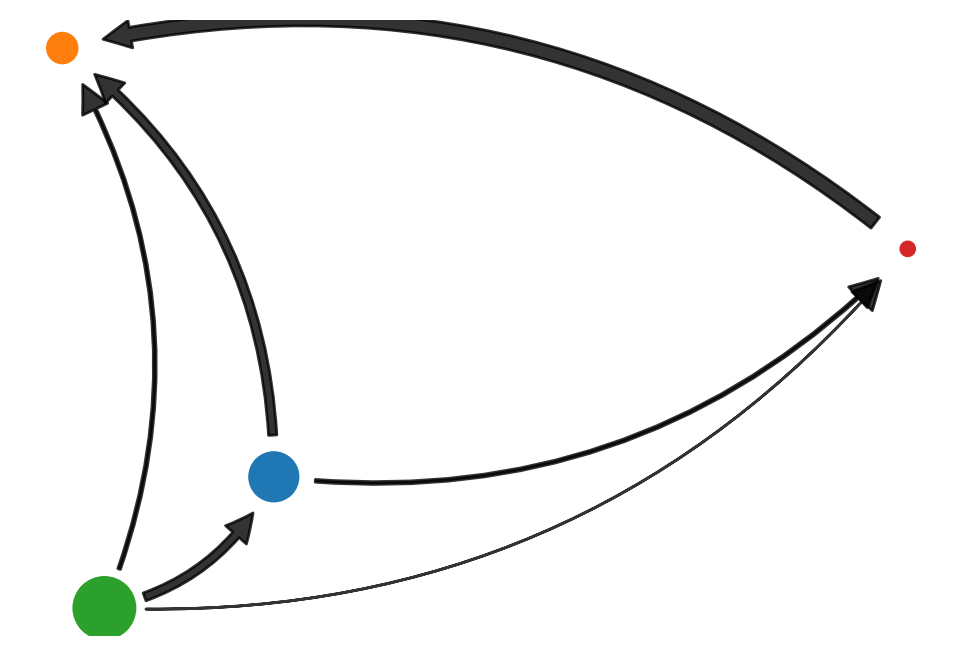

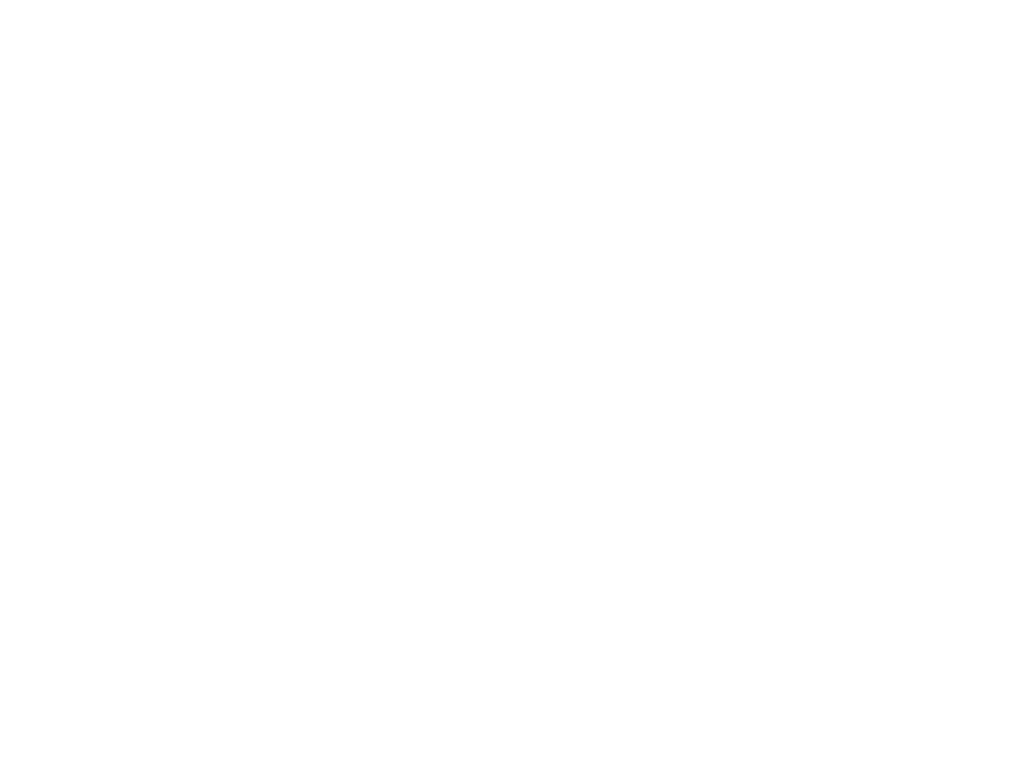

In [157]:
plt.show()

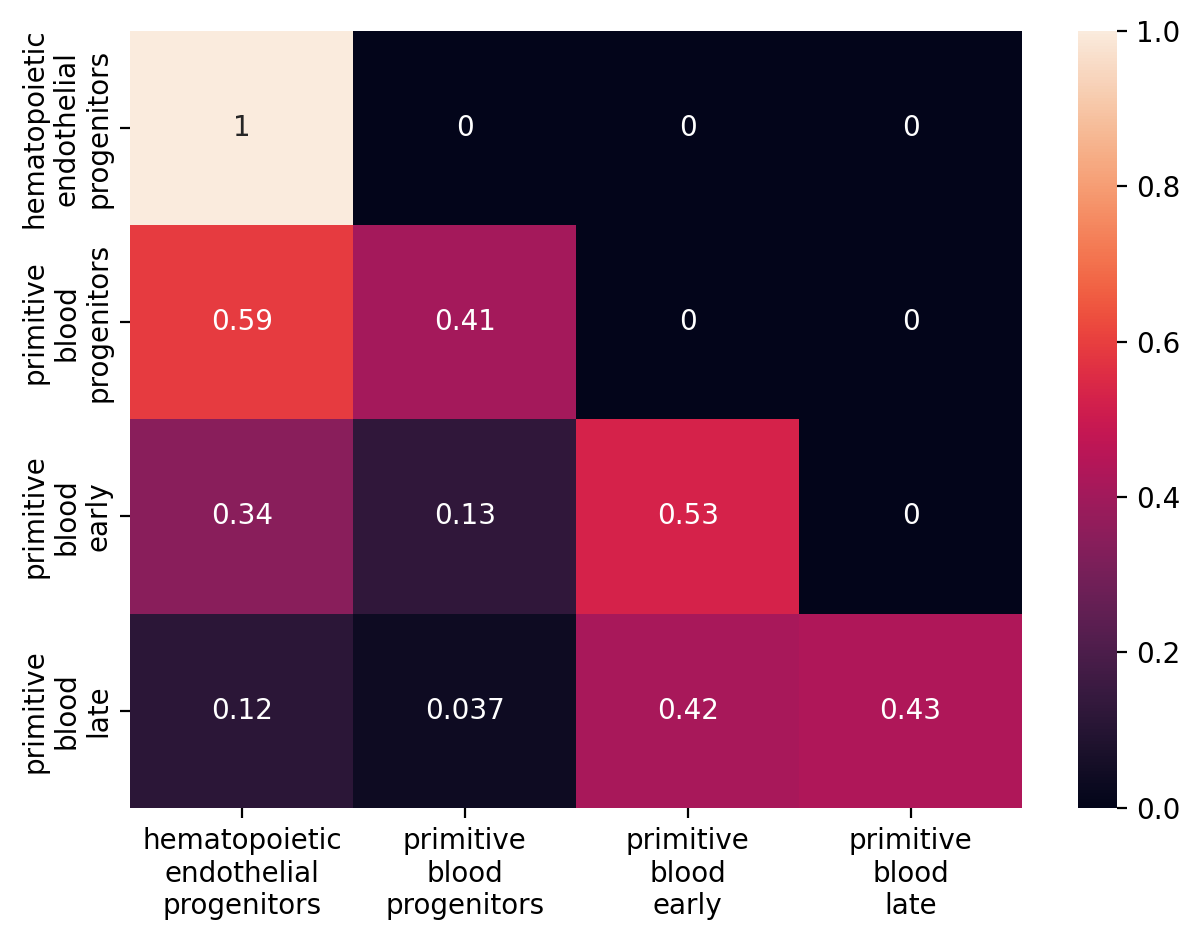

In [144]:
transition_mat = adata.uns['cell_states_graph']['group_graph']
transition_groups = adata.uns['cell_states_graph']['group_names']
transition_mat = pd.DataFrame(transition_mat, index=transition_groups, columns=transition_groups)

order = ['hematopoietic/endothelial progenitors', 
         'primitive blood progenitors',
         'primitive blood early',
         'primitive blood late']

import seaborn as sns
fig, ax = plt.subplots()
transition_mat = transition_mat[order].loc[order]
transition_mat = transition_mat/transition_mat.sum(1)
transition_mat.index = [i.replace(' ', '\n').replace('/', '\n') for i in transition_mat.index]
transition_mat.columns = transition_mat.index
sns.heatmap(transition_mat, annot=True, ax=ax)
for label in ax.get_yticklabels():
    label.set_horizontalalignment('center')
    label.set_fontsize(10)
    label.set_position((label.get_position()[0]-0.05, label.get_position()[1]))
for label in ax.get_xticklabels():
    label.set_horizontalalignment('center')
    label.set_fontsize(10)
    
ax.yaxis.set_label_coords(1, 1)
plt.tight_layout()
plt.show()

In [15]:
data_path = '/data/liangzhen/wangk_embryogenesis/data/GSM3302833_embryo7/'
count = pd.read_csv(data_path+'scRNA_raw_counts.csv', index_col=0).T
metadata = pd.read_csv(data_path+'scRNA_metadata_blood_development.csv', index_col=0)
count = count.loc[metadata.index]

In [16]:
count.shape

(1587, 18252)

In [137]:
sd = pv.scData(count=count, cell_names=count.index, cell_states=metadata['cluster'].to_numpy())
sd.normalize_filter()
transfer_vel = []
for i in sd.x_normed.columns:
    if i in vels.index:
        transfer_vel.append(vels.loc[i]['velocity'])
    else:
        transfer_vel.append(0)
sd.velocity = np.array(transfer_vel)

In [138]:
sd.dimensionality_reduction('x_normed', perplexity=10)
pv.velocity_embedding(sd, target='x_normed')

  0%|          | 0/1587 [00:00<?, ?it/s]

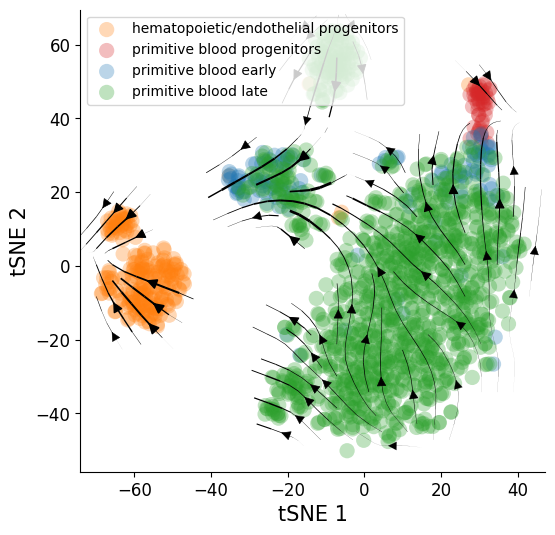

In [139]:
fig, ax = plt.subplots()
for i in [13,36,9,22]:
    ax.scatter(sd.Xdr.iloc[np.array(sd.cell_states)==i, 0], sd.Xdr.iloc[np.array(sd.cell_states)==i, 1], c=cmap[color_map[i]], edgecolors='none', s=120, alpha=0.3, label=state_map[i])
ax = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax, 'stream',streamdensity=1, radius=5, lw_coef=5000, arrowsize=1.5)
ax.figure.set_size_inches(6, 6)
ax.set_xlabel('tSNE 1', fontsize=15)
ax.set_ylabel('tSNE 2', fontsize=15)
# cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
# plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
ax.legend(fontsize=10)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# plt.savefig('./figures/embryo3_blood/stream.pdf', dpi='figure', format='pdf')

In [140]:
sd_em7 = deepcopy(sd)

In [141]:
sds = [sd_em1, sd_em2, sd_em4, sd_em5, sd_em6, sd_em7]

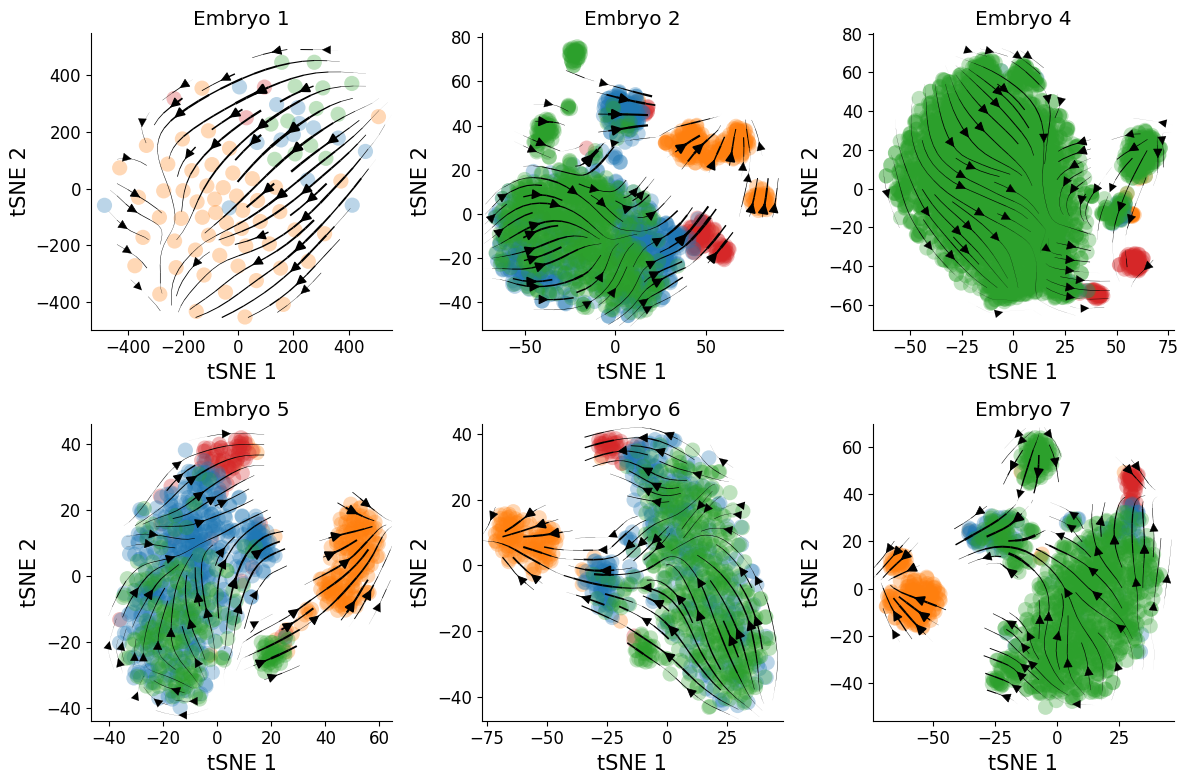

In [155]:
fig, ax = plt.subplots(2, 3, figsize=(12, 8))
for ind, sd in enumerate(sds):
    for i in [13,36,9,22]:
        ax[ind//3][ind%3].scatter(sd.Xdr.iloc[np.array(sd.cell_states)==i, 0], sd.Xdr.iloc[np.array(sd.cell_states)==i, 1], c=cmap[color_map[i]], edgecolors='none', s=120, alpha=0.3, label=state_map[i])
    if not ind:
        ax[0][0] = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax[0][0], 'stream',streamdensity=0.8, radius=160, lw_coef=100, arrowsize=1.5)
    else:
        ax[ind//3][ind%3] = pv.ana_utils.velocity_plot(sd.Xdr.to_numpy(), sd.velocity_embeded, ax[ind//3][ind%3], 'stream',streamdensity=1, radius=5, lw_coef=5000, arrowsize=1.5)
    # ax[ind//3][ind%3].figure.set_size_inches(6, 6)
    ax[ind//3][ind%3].set_xlabel('tSNE 1', fontsize=15)
    ax[ind//3][ind%3].set_ylabel('tSNE 2', fontsize=15)
    # cbaxes = inset_axes(ax, width="3%", height="30%", loc='lower right') 
    # plt.colorbar(scatter, cax=cbaxes, orientation='vertical')
    # ax[ind//3][ind%3].legend(fontsize=10)
    ax[ind//3][ind%3].spines['right'].set_visible(False)
    ax[ind//3][ind%3].spines['top'].set_visible(False)
    if ind < 2:
        ax[ind//3][ind%3].set_title(f'Embryo {ind+1}')
    else:
        ax[ind//3][ind%3].set_title(f'Embryo {ind+2}')
plt.tight_layout()
# plt.savefig('./figures/embryo3_blood/stream.pdf', dpi='figure', format='pdf')